<a href="https://colab.research.google.com/github/nmach22/Promoter-Classification/blob/main/notebooks/train_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Env**

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/nmach22/Promoter-Classification.git
!pip install -r ./Promoter-Classification/requirements.txt

In [2]:
import sys
import torch

ROOT_DIR = '/content/Promoter-Classification'
sys.path.append(ROOT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:

import os
import yaml

from pathlib import Path

from utils.data_split import dataset_split
from utils.encoding_functions import KmerEncoding
from utils.fasta_dataset import FastaDataset
from utils.encoding_functions import *

_PATH_TO_ROOT = os.path.join(Path.cwd().absolute(), 'Promoter-Classification')
_DEFAULT_CONFIG_PATH = os.path.join(_PATH_TO_ROOT, 'config', 'config.yaml')

with open(_DEFAULT_CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

In [4]:
data_name = config['data']['bacillus']

prom_path = f"{ROOT_DIR}/{data_name['promoter_fasta']}"
non_prom_path = f"{ROOT_DIR}/{data_name['non_promoter_fasta']}"
seq_length = data_name['seq_len']

In [19]:
data_name_e = config['data']['ecoli']

prom_path_e = f"{ROOT_DIR}/{data_name_e['promoter_fasta']}"
non_prom_path_e = f"{ROOT_DIR}/{data_name_e['non_promoter_fasta']}"
seq_length_e = data_name_e['seq_len']

In [20]:
assert seq_length == seq_length_e

In [26]:
dataset_ecoli = FastaDataset(prom_path_e, non_prom_path_e, seq_len=seq_length)

print(f"Ecoli dataset has {len(dataset_ecoli.sequences)} sequences and {len(dataset_ecoli.labels)} labels.")

Ecoli dataset has 3839 sequences and 3839 labels.


In [27]:
# k3_encoder = KmerEncoding(k=3)
dataset = FastaDataset(prom_path, non_prom_path, seq_len=seq_length)
# train_ds, val_ds, test_ds = dataset_split(dataset)
print(f"Bacilus dataset has {len(dataset.sequences)} sequences and {len(dataset.labels)} labels.")

Bacilus dataset has 1373 sequences and 1373 labels.


In [28]:
dataset.sequences.extend(dataset_ecoli.sequences)
dataset.labels.extend(dataset_ecoli.labels)

print(f"Combined dataset now has {len(dataset.sequences)} sequences and {len(dataset.labels)} labels.")

Combined dataset now has 5212 sequences and 5212 labels.


In [29]:
# Re-split the combined dataset to update train, val, and test sets
train_ds, val_ds, test_ds = dataset_split(dataset)

print(f"New split sizes:\nTrain: {len(train_ds)}\nVal:   {len(val_ds)}\nTest:  {len(test_ds)}")

New split sizes:
Train: 3648
Val:   781
Test:  783


In [30]:
len(test_ds[0][0])

81

### 1. Setup Data

In [31]:
batch_size = config['train']['batch_size']

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### 2. Initialize Model, Loss, and Optimizer

In [32]:
from models.lstm import PromoterLSTM
from torch import nn

model = PromoterLSTM(
    hidden_dim=64,
    num_layers=2,
    bidirectional=True,
    fc_hidden_dims=[64],
    dropout=0.3,
    use_cnn=True,
    cnn_kernel_size=7,
    use_layer_norm=True,
    pooling_strategy='attention'
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### 3. Training Loop

✓ CUDA is available
  Device: Tesla T4
  Device count: 1
  CUDA version: 12.6
Epoch 1/100 | Train Loss: 0.5089 | Val Loss: 0.3942
  Train accuracy: 0.7719
  Val accuracy: 0.8310
  Train sensitivity: 0.1462
  Val sensitivity: 0.5138
  Train specificity: 0.9614
  Val specificity: 0.9267
  Train correlation_coef: 0.1863
  Val correlation_coef: 0.4887
Epoch 2/100 | Train Loss: 0.3999 | Val Loss: 0.3979
  Train accuracy: 0.8163
  Val accuracy: 0.8079
  Train sensitivity: 0.4764
  Val sensitivity: 0.7017
  Train specificity: 0.9193
  Val specificity: 0.8400
  Train correlation_coef: 0.4422
  Val correlation_coef: 0.5060
Epoch 3/100 | Train Loss: 0.3907 | Val Loss: 0.3597
  Train accuracy: 0.8210
  Val accuracy: 0.8271
  Train sensitivity: 0.5271
  Val sensitivity: 0.6243
  Train specificity: 0.9100
  Val specificity: 0.8883
  Train correlation_coef: 0.4691
  Val correlation_coef: 0.5136
Epoch 4/100 | Train Loss: 0.3738 | Val Loss: 0.3688
  Train accuracy: 0.8279
  Val accuracy: 0.8207
  Trai

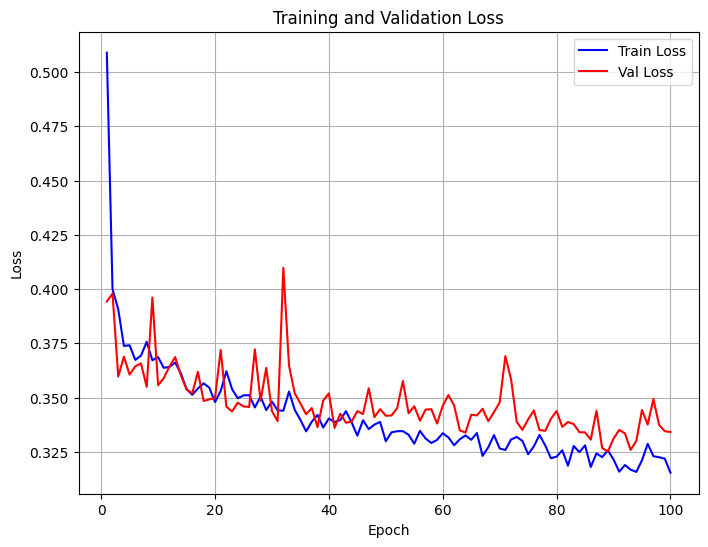

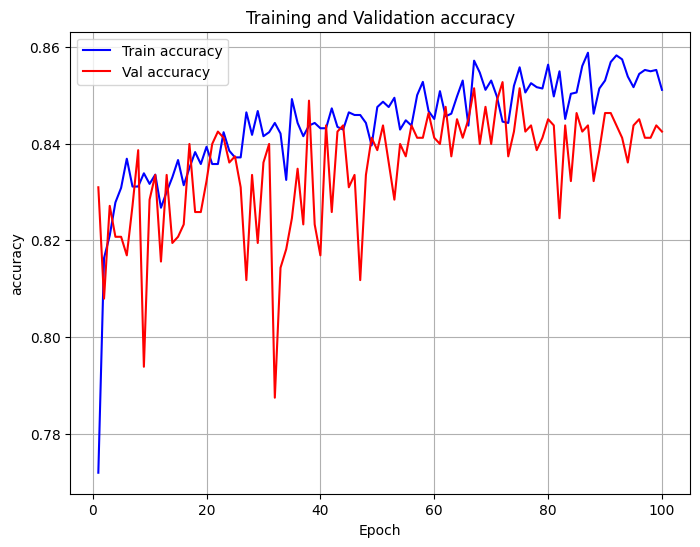

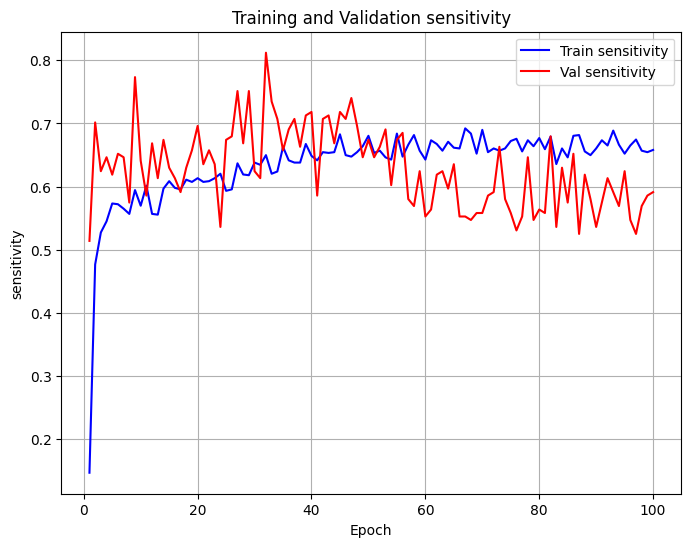

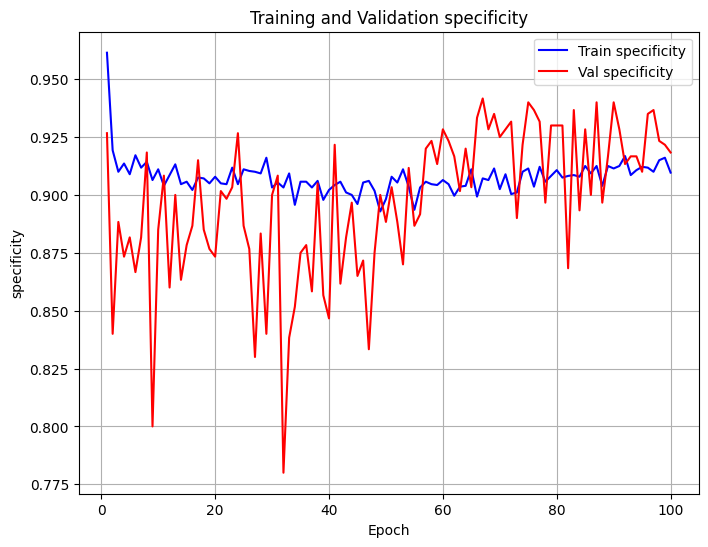

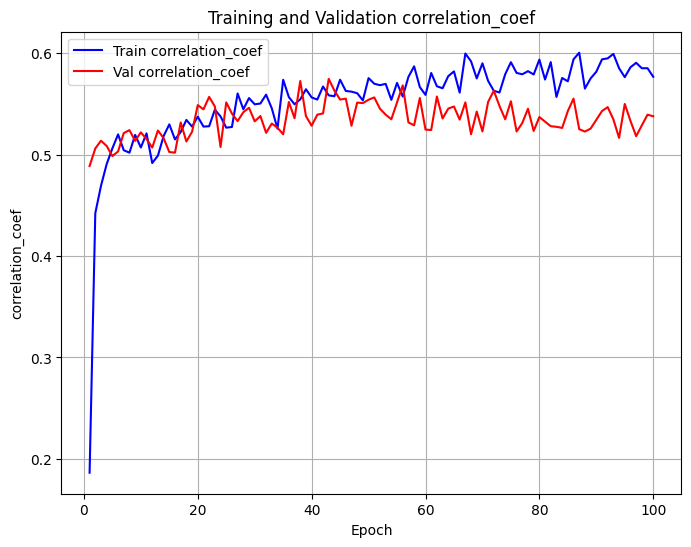

In [33]:
from utils.train import Train

train = Train(model, train_loader, val_loader, optimizer, criterion)
train.train(100, True)

In [34]:
save_dir = f'/content/drive/MyDrive/checkpoints_bio/lstm/combined'

os.makedirs(save_dir, exist_ok=True)

## Evaluation

In [35]:
from eval.train_evals import TrainEvals
from eval.metrics import *

fpr, tpr, roc_auc, all_labels, all_predictions = calculate_roc_data(model,test_loader,False,device)

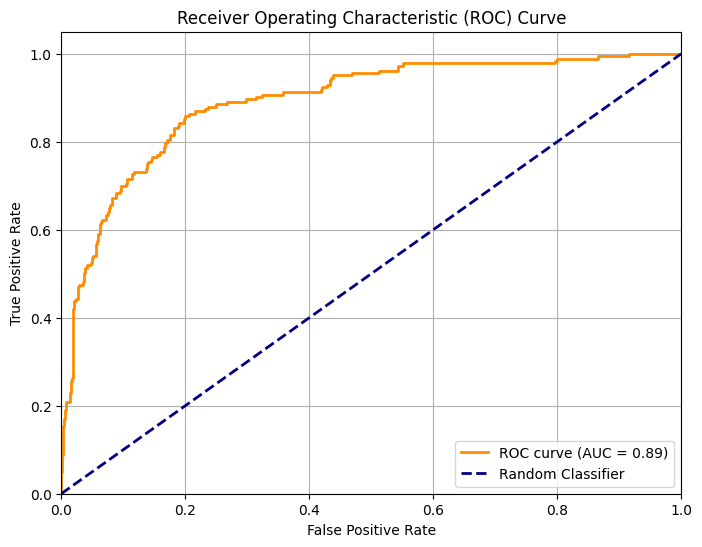

In [36]:
plot_roc_curve(fpr, tpr, roc_auc,save_dir=save_dir,
                file_name='combined_roc_curve'
               )

In [37]:
thresholds = np.linspace(0, 1, 100)

# Call the function to find the optimal threshold
optimal_threshold, max_f1_score = find_optimal_threshold(all_labels, all_predictions, thresholds)

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum F1-score at optimal threshold: {max_f1_score:.4f}")

Optimal Threshold: 0.4545
Maximum F1-score at optimal threshold: 0.6938


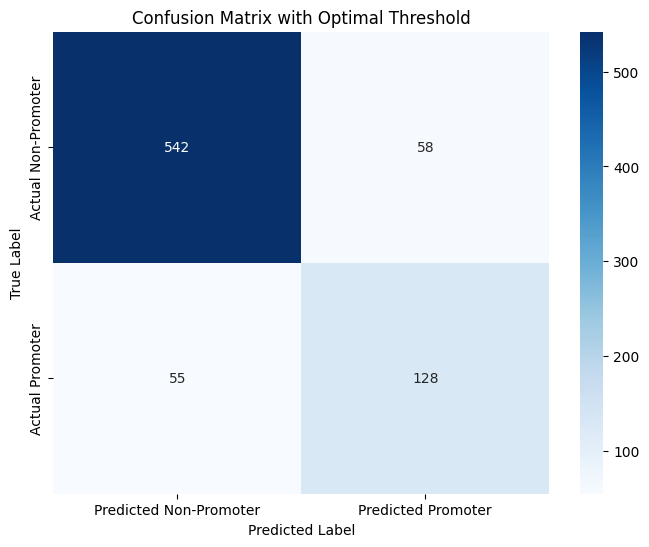

In [38]:

# Assuming optimal_threshold is already defined or will be defined next
# For now, let's plot with a default 0.5 or the previously calculated optimal_threshold if it exists
plot_confusion_matrix(all_labels, all_predictions, threshold=optimal_threshold, title='Confusion Matrix with Optimal Threshold',
                      save_dir=save_dir,
                      file_name='combined_confusion_matrix'
                      )

In [39]:

# Call the function to calculate and print metrics using the optimal_threshold
metrics_dict = calculate_metrics(all_labels, all_predictions, optimal_threshold)

print(f"Metrics at Optimal Threshold ({optimal_threshold:.4f}):")
for metric_name, value in metrics_dict.items():
    print(f"  {metric_name}: {value:.4f}")

Metrics at Optimal Threshold (0.4545):
  Accuracy: 0.8557
  Precision: 0.6882
  Recall (Sensitivity): 0.6995
  Negative Recall (Specificity): 0.9033
  F1-Score: 0.6938
  Correlation Coefficient (MCC): 0.5994


In [40]:
from utils.encoding_functions import *
seq = dataset.sequences[0]

kmers = random_substitution_top_kmers(
    model,
    seq,
    encoding_func=one_hot_encode,
    seq_len=81,
    window_size=7,
    top_k=10,
    device=device
)

for pos, kmer, score in kmers:
    print(f"Position {pos}: {kmer}  (importance={score:.4f})")

Position 29: ACAAATT  (importance=0.1704)
Position 14: TATTTTT  (importance=0.1668)
Position 21: TTGTCTG  (importance=0.1253)
Position 11: TTCTATT  (importance=0.1196)
Position 12: TCTATTT  (importance=0.1065)
Position 13: CTATTTT  (importance=0.0957)
Position 16: TTTTTTT  (importance=0.0898)
Position 27: GTACAAA  (importance=0.0668)
Position 47: ACTACAA  (importance=0.0653)
Position 54: TAAAGGG  (importance=0.0650)


In [41]:

import json
import os
json_file_name = "combined_json"

# Prepare kmer data for JSON serialization (convert numpy types to native Python types)
kmer_data = [
    {
        "position": int(pos),
        "kmer": kmer,
        "importance": float(score)
    }
    for pos, kmer, score in kmers
]

# Prepare metrics data for JSON serialization (convert numpy types to native Python types)
# Ensure all values in metrics_dict are native Python types
metrics_serializable = {
    key: float(value) if isinstance(value, np.floating) else value
    for key, value in metrics_dict.items()
}

# Combine all data into a single dictionary
output_data = {
    "top_kmers": kmer_data,
    "metrics": metrics_serializable
}

# Define the full path for the JSON file
json_file_path = os.path.join(save_dir, f"{json_file_name}.json")

# Save the data to a JSON file
with open(json_file_path, 'w') as f:
    json.dump(output_data, f, indent=4)

print(f"Successfully saved top kmers and metrics to {json_file_path}")

Successfully saved top kmers and metrics to /content/drive/MyDrive/checkpoints_bio/lstm/combined/combined_json.json
